<a href="https://colab.research.google.com/github/Ashan-KS/ML_CW/blob/main/Machine_Learning_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Corpus Preparation**

## **1.1 Imports**

In [59]:
# Import necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

## **1.2 Fine tuning to Dataset's logic**

In [34]:
# Loading the dataset
df = pd.read_csv('/content/bank-additional-full.csv', delimiter=';')

In [35]:
# Identifying duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Removing duplicates
df = df.drop_duplicates()
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 12
Number of duplicate rows: 0


In [36]:
# Replacing the 999 in pdays with -1
df['pdays'] = df['pdays'].replace(999, -1)

# Removing rows with duration = 0
df = df[df['duration'] != 0]

# Fix: Set `previous` to 0 where `pdays == -1` and `previous != 0`
df.loc[(df['pdays'] == -1) & (df['previous'] != 0), 'previous'] = 0

<ipython-input-36-d60c01b67faf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pdays'] = df['pdays'].replace(999, -1)


## **1.3 Features Overview**

In [37]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

In [38]:
# Shape and head of the dataset
print("Dataset shape: ",df.shape,"\n")
df.head()

Dataset shape:  (41172, 21) 



,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [39]:
# Statistics of all numerical columns
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41172.000000,41172.000000,41172.000000,41172.000000,41172.000000,41172.000000,41172.000000,41172.000000,41172.000000,41172.000000
mean,40.023268,258.340911,2.567667,-0.741888,0.061109,0.081956,93.575742,-40.502771,3.621339,5167.036105
std,10.420474,259.305416,2.770200,1.510611,0.360354,1.570883,0.578848,4.627790,1.734428,72.252599
min,17.000000,1.000000,1.000000,-1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,-1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,-1.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,-1.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [40]:
for feature in categorical_cols:
    print(f"Occurrences of target 'y' for feature: {feature}")
    print(df.groupby(feature)['y'].value_counts())
    print("\n")

Occurrences of target 'y' for feature: job
job            y  
admin.         no     9067
               yes    1351
blue-collar    no     8613
               yes     638
entrepreneur   no     1332
               yes     124
housemaid      no      954
               yes     106
management     no     2595
               yes     328
retired        no     1284
               yes     434
self-employed  no     1272
               yes     149
services       no     3644
               yes     323
student        no      600
               yes     275
technician     no     6009
               yes     730
unemployed     no      870
               yes     144
unknown        no      293
               yes      37
Name: count, dtype: int64


Occurrences of target 'y' for feature: marital
marital   y  
divorced  no      4134
          yes      476
married   no     22387
          yes     2531
single    no      9944
          yes     1620
unknown   no        68
          yes       12
Name: count, dtyp

In [41]:
for feature in numerical_cols:
    print(f"Occurrences of target 'y' for feature: {feature}")

    # Create a dynamic name for the binned column
    binned_feature = 'binned_' + feature

    # Create bins for the current feature (10 bins)
    df[binned_feature] = pd.cut(df[feature], bins=10)

    # Group by the binned values and calculate the count of target 'y'
    print(df.groupby(binned_feature)['y'].value_counts())
    print("\n")

    # Drop the binned column after processing
    df.drop(columns=[binned_feature], inplace=True)

Occurrences of target 'y' for feature: age
binned_age      y  
(16.919, 25.1]  no      1316
                yes      349
(25.1, 33.2]    no      9951
                yes     1389
(33.2, 41.3]    no     10935
                yes     1096
(41.3, 49.4]    no      7449
                yes      636
(49.4, 57.5]    no      5251
                yes      570
(57.5, 65.6]    no      1303
                yes      309
(65.6, 73.7]    no       182
                yes      135
(73.7, 81.8]    yes      104
                no        98
(81.8, 89.9]    yes       46
                no        43
(89.9, 98.0]    no         5
                yes        5
Name: count, dtype: int64


Occurrences of target 'y' for feature: duration
binned_duration   y  
(-3.917, 492.7]   no     33608
                  yes     2512
(492.7, 984.4]    no      2518
                  yes     1534
(984.4, 1476.1]   yes      455
                  no       326
(1476.1, 1967.8]  yes       95
                  no        57
(1967.8, 24

<ipython-input-41-36cc5875f3a6>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(binned_feature)['y'].value_counts())
<ipython-input-41-36cc5875f3a6>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(binned_feature)['y'].value_counts())
<ipython-input-41-36cc5875f3a6>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(binned_feature)['y'].value_counts())
<ipython-input-4

Occurrences of target 'y' for feature: nr.employed
binned_nr.employed   y  
(4963.336, 4990.05]  no       334
                     yes      301
(4990.05, 5016.5]    yes      772
                     no       651
(5016.5, 5042.95]    no       700
                     yes      542
(5042.95, 5069.4]    no         0
                     yes        0
(5069.4, 5095.85]    no      1069
                     yes      593
(5095.85, 5122.3]    no      7438
                     yes     1092
(5122.3, 5148.75]    no         0
                     yes        0
(5148.75, 5175.2]    no         0
                     yes        0
(5175.2, 5201.65]    no     10980
                     yes      473
(5201.65, 5228.1]    no     15361
                     yes      866
Name: count, dtype: int64




<ipython-input-41-36cc5875f3a6>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(binned_feature)['y'].value_counts())


In [42]:
# Ensure 'y' is encoded as 1's and 0's
if 'y' in df.columns:
    df['y'] = df['y'].map({'yes': 1, 'no': 0})
else:
    print("'y' column is missing in the DataFrame.")

Correlation with target 'y':
y                 1.000000
duration          0.405285
previous          0.293002
pdays             0.279050
cons.conf.idx     0.054799
age               0.030401
campaign         -0.066340
cons.price.idx   -0.136153
emp.var.rate     -0.298313
euribor3m        -0.307768
nr.employed      -0.354688
Name: y, dtype: float64


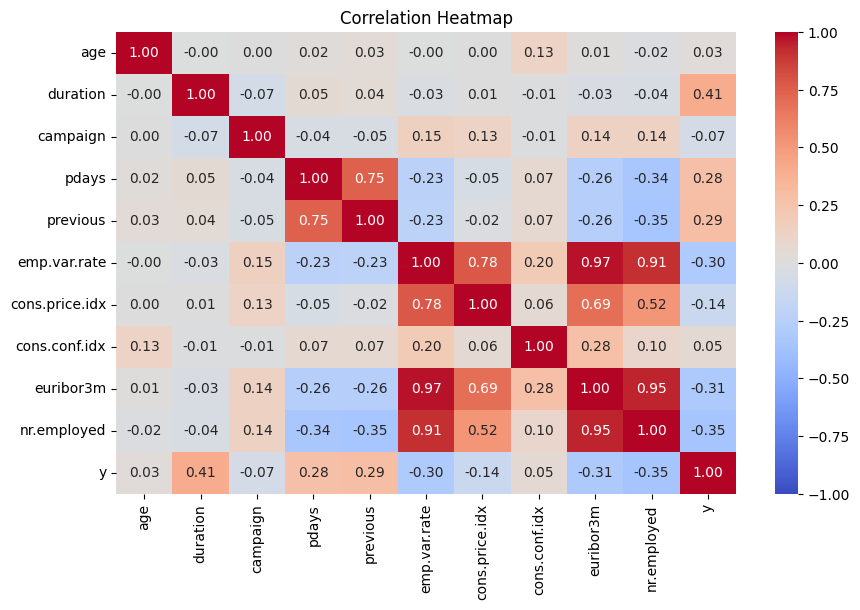

In [43]:
# Select numerical columns (int64 or float64 types)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Compute the correlation matrix for numerical columns
correlation_matrix = df[numerical_cols].corr()

# Add correlation with target 'y'
correlation_with_y = correlation_matrix['y'].sort_values(ascending=False)

# Display the correlations with 'y'
print("Correlation with target 'y':")
print(correlation_with_y)

# Plot the heatmap for the correlation matrix (including 'y' as a row and column)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [44]:
# Print unique values for each categorical column
for column in categorical_cols:
    print('Column:', column)
    print(df[column].unique())
    print()

Column: job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Column: marital
['married' 'single' 'divorced' 'unknown']

Column: education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Column: default
['no' 'unknown' 'yes']

Column: housing
['no' 'yes' 'unknown']

Column: loan
['no' 'yes' 'unknown']

Column: contact
['telephone' 'cellular']

Column: month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Column: day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']

Column: poutcome
['nonexistent' 'failure' 'success']

Column: y
[0 1]



In [45]:
# Check the distribution of the target variable
target_distribution = df['y'].value_counts()

# Display the class imbalance
print("Class Distribution in Target Variable (y):")
print(target_distribution)

print("\nThe count of 'no' as the target variable is much greater than that of 'yes', therefore, fixing this class imbalance is crucial")

Class Distribution in Target Variable (y):
y
0    36533
1     4639
Name: count, dtype: int64

The count of 'no' as the target variable is much greater than that of 'yes', therefore, fixing this class imbalance is crucial


## **1.4 Preprocessing**

### **1.4.1 Handling null values**

In [46]:
# Checking for null values
print(df.isnull().sum())

print("\nThere are no null values in this dataset")

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

There are no null values in this dataset


### **1.4.2 Splitting the dataset**

In [47]:
# Extract features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y']

In [48]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [49]:
# Select numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Select categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

### **1.4.3 Handling the class imbalance of the training set**

In [50]:
# Get categorical column indices
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

# Apply SMOTENC to handle imbalanced classes
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train, y_train = smote_nc.fit_resample(X_train, y_train)

# Check the new distribution
balanced_distribution = pd.Series(y_train).value_counts()
print("\nClass Distribution After Applying SMOTE:")
print(balanced_distribution)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



Class Distribution After Applying SMOTE:
y
0    29226
1    29226
Name: count, dtype: int64


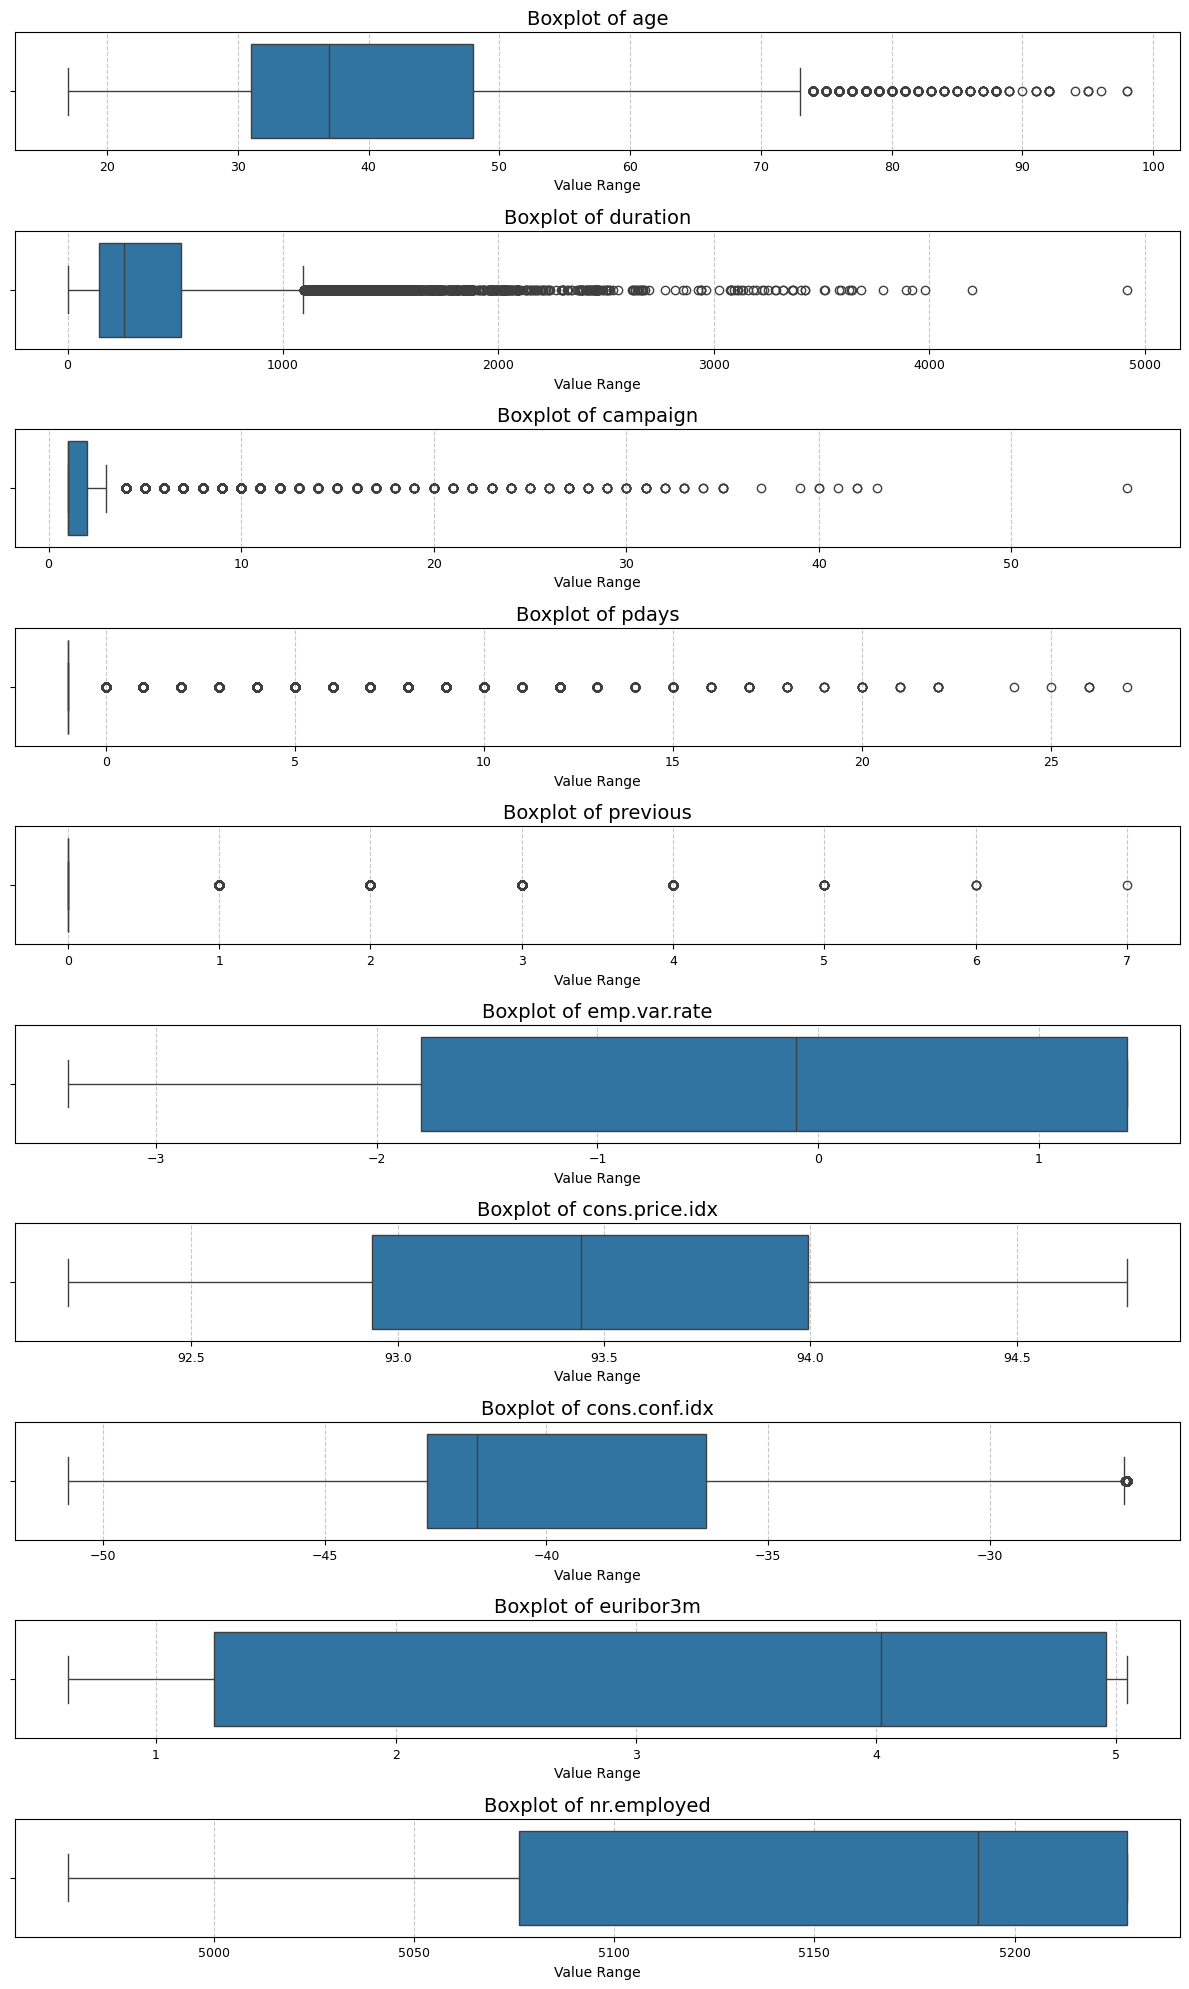


age: 850 outliers (1.45%)

duration: 2769 outliers (4.74%)

campaign: 7748 outliers (13.26%)

pdays: 8910 outliers (15.24%)

previous: 5102 outliers (8.73%)

emp.var.rate: 0 outliers (0.00%)

cons.price.idx: 0 outliers (0.00%)

cons.conf.idx: 759 outliers (1.30%)

euribor3m: 0 outliers (0.00%)

nr.employed: 0 outliers (0.00%)


In [30]:
# Create subplots for each numerical feature
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(12, 20), sharex=False)

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=X_train, x=col, ax=axes[i], orient="h")
    axes[i].set_title(f"Boxplot of {col}", fontsize=14)
    axes[i].set_xlabel("Value Range", fontsize=10)
    axes[i].grid(axis="x", linestyle="--", alpha=0.7)
    axes[i].tick_params(axis="x", labelsize=9)
    axes[i].tick_params(axis="y", labelsize=9)

plt.tight_layout()
plt.show()

# Calculate outliers using IQR method
def get_outliers_count(X_train, column):
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = X_train[(X_train[column] < lower_bound) | (X_train[column] > upper_bound)][column]
    return len(outliers)

# Print outlier counts
for col in numerical_cols:
    outlier_count = get_outliers_count(X_train, col)
    outlier_percentage = (outlier_count / len(X_train)) * 100
    print(f"\n{col}: {outlier_count} outliers ({outlier_percentage:.2f}%)")

In [31]:
def cap_outliers(df, column, lower_limit=None, upper_limit=None):
    if lower_limit is not None and upper_limit is not None:
        df[column] = df[column].clip(lower=lower_limit, upper=upper_limit)

# Apply capping to specific columns
cap_outliers(X_train, 'age', upper_limit=90)      # Cap age at 90
cap_outliers(X_train, 'campaign', upper_limit=10)  # Cap campaign at 10
cap_outliers(X_train, 'previous', upper_limit=3)   # Cap previous at 3

### **1.4.4 Scaling the training & testing sets**

In [53]:
# Initialize the scaler
scaler = StandardScaler()

if len(categorical_cols) > 0:
    # Separate categorical and numerical features
    X_train_categorical = X_train[categorical_cols]
    X_train_numerical = X_train.drop(columns=categorical_cols)

    X_test_categorical = X_test[categorical_cols]
    X_test_numerical = X_test.drop(columns=categorical_cols)

    # Scale only numerical features
    X_train_numerical = scaler.fit_transform(X_train_numerical)
    X_test_numerical = scaler.transform(X_test_numerical)

    # Convert scaled numerical features back to DataFrames with original column names
    X_train_numerical = pd.DataFrame(X_train_numerical, columns=X_train.drop(columns=categorical_cols).columns, index=X_train.index)
    X_test_numerical = pd.DataFrame(X_test_numerical, columns=X_test.drop(columns=categorical_cols).columns, index=X_test.index)

    # Combine the scaled numerical features with the categorical features (no scaling on categorical)
    X_train = pd.concat([X_train_numerical, X_train_categorical], axis=1)
    X_test = pd.concat([X_test_numerical, X_test_categorical], axis=1)
else:
    # If no categorical columns, just apply scaling to the entire dataset
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

X_train.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,2.667364,-0.706482,-0.518493,-0.323579,-0.271356,-0.705138,0.871712,0.360100,-1.094383,-1.651979,retired,married,university.degree,no,yes,no,cellular,aug,thu,nonexistent
1,1.372014,0.484377,0.357658,-0.323579,-0.271356,-1.402667,-2.052767,1.674148,-1.129303,-0.682534,services,single,high.school,no,no,yes,cellular,aug,tue,nonexistent
2,-1.045973,0.249599,-0.518493,1.561253,10.143148,-0.763265,0.629874,0.036349,-1.207608,-1.456027,student,single,high.school,no,no,yes,cellular,may,wed,success
3,-0.527833,-0.251070,-0.080417,-0.323579,-0.271356,-0.763265,-0.944476,-1.144389,-0.861584,-0.420119,admin.,married,high.school,no,no,no,cellular,may,tue,nonexistent
4,-0.873260,-0.143582,7.366863,-0.323579,-0.271356,1.096813,0.697140,-0.477843,1.052132,1.058112,technician,married,professional.course,no,no,no,cellular,jul,tue,nonexistent


### **1.4.5 Encoding the training & testing sets**

In [54]:
if len(categorical_cols) > 0:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit the encoder on the training data and transform it
    X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
    X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))

    # Transform the testing data using the same encoder
    X_test_encoded = encoder.transform(X_test[categorical_cols])
    X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

    # Combine encoded categorical features with numerical ones for both X_train and X_test
    X_train = pd.concat([X_train.drop(columns=categorical_cols).reset_index(drop=True), X_train_encoded], axis=1)
    X_test = pd.concat([X_test.drop(columns=categorical_cols).reset_index(drop=True), X_test_encoded], axis=1)
else:
    # If no categorical columns, just reset the index for both
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)

X_train.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,2.667364,-0.706482,-0.518493,-0.323579,-0.271356,-0.705138,0.871712,0.360100,-1.094383,-1.651979,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.372014,0.484377,0.357658,-0.323579,-0.271356,-1.402667,-2.052767,1.674148,-1.129303,-0.682534,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.045973,0.249599,-0.518493,1.561253,10.143148,-0.763265,0.629874,0.036349,-1.207608,-1.456027,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.527833,-0.251070,-0.080417,-0.323579,-0.271356,-0.763265,-0.944476,-1.144389,-0.861584,-0.420119,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.873260,-0.143582,7.366863,-0.323579,-0.271356,1.096813,0.697140,-0.477843,1.052132,1.058112,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# **2. Implementation**

## **2.1 Random Forest Implementation**

In [55]:
# param_grid_rfc = {
#     'n_estimators': [300, 350, 400],
#     'min_samples_split': [10, 15, 20],
#     'max_depth': [15, 20, 30],
#     'min_samples_leaf': [1],
#     'criterion': ['entropy','gini']
# }

In [56]:
# Initialize Random Forest with class weight balancing
rf_model = RandomForestClassifier(
    random_state=42,  # Ensures reproducibility
    n_jobs=-1,        # Use all available processors
    criterion='entropy',  # Use 'entropy' criterion
    max_depth=30,          # Set the maximum depth of the tree
    min_samples_leaf=1,    # Minimum number of samples required to be at a leaf node
    min_samples_split=10,  # Minimum number of samples required to split an internal node
    n_estimators=350      # Number of trees in the forest
)

# Train the model
rf_model.fit(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)  # cv=5 means 5-fold cross-validation

In [60]:
# Make predictions
rf_predictions = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Performance:\n")
print(f"Mean CV Score: {np.mean(cv_scores):.2f}")
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_predictions))

# ROC-AUC score (for binary classification)
if len(set(y_test)) == 2:  # Check if it's binary classification
    rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
    print(f"ROC-AUC Score: {rf_roc_auc:.2f}")
else:
    print("ROC-AUC is only applicable for binary classification.")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rf_predictions))

Random Forest Classifier Performance:

Mean CV Score: 0.94
Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7307
           1       0.56      0.70      0.62       928

    accuracy                           0.90      8235
   macro avg       0.76      0.81      0.78      8235
weighted avg       0.92      0.90      0.91      8235

ROC-AUC Score: 0.94

Confusion Matrix:
[[6799  508]
 [ 282  646]]


## **2.2 Nueral Network Implementation**

In [ ]:
# # Define the parameter grid
# param_grid_nn = {
#     'hidden_layer_sizes': [(50, 50), (100, 50), (50, 100, 50)],  # Experiment with additional layer configurations
#     'activation': ['tanh', 'relu'],  # Add 'relu' to explore its performance
#     'solver': ['adam'],  # Keep 'adam' as it worked well
#     'alpha': [0.001, 0.01, 0.1],  # Test smaller and larger values for regularization
#     'batch_size': [64, 128],  # Increase batch size for potential improvements
#     'learning_rate': ['constant', 'adaptive'],  # Retain both options
#     'max_iter': [200, 300, 400],  # Increase max iterations for potential convergence
#     'early_stopping': [True],  # Keep as True
# }

In [61]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Print the number of components
print(f"Number of components selected: {pca.n_components_}")
print("Unique classes in y_train:", np.unique(y_train))

Number of components selected: 28
Unique classes in y_train: [0 1]


In [62]:
# Initialize the MLPClassifier with the best parameters directly
mlp = MLPClassifier(
    random_state=42,
    activation='tanh',
    alpha=0.01,
    batch_size=64,
    early_stopping=True,
    hidden_layer_sizes=(50, 50),
    learning_rate='constant',
    max_iter=200,
    solver='adam'
)

# Train the neural network
mlp.fit(X_train, y_train)

# Evaluate the model on the training set
train_predictions = mlp.predict(X_train)

In [63]:
print("\nNeural Network Performance: \n")

train_accuracy = accuracy_score(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the model on the test set

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC score
if len(np.unique(y)) == 2:  # Ensure it's binary classification
    y_pred_prob = mlp.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print(f"ROC-AUC Score: {roc_auc:.2f}")

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Neural Network Performance: 

Training Accuracy: 0.95
Test Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7307
           1       0.52      0.71      0.60       928

    accuracy                           0.89      8235
   macro avg       0.74      0.81      0.77      8235
weighted avg       0.91      0.89      0.90      8235

ROC-AUC Score: 0.93

Confusion Matrix:
[[6698  609]
 [ 271  657]]


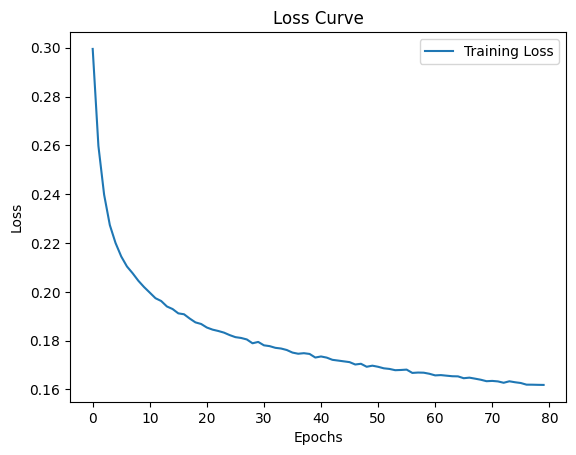

In [64]:
# Plot the loss curve
plt.figure()
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()